In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)

In [2]:
trainDir = r"/home/trojan/Desktop/dimentia/dataset/data_2categ/data_augmented/train"
valDir = r"/home/trojan/Desktop/dimentia/dataset/data_2categ/data_augmented/validation"
input_shape = Input(shape=(256, 256, 3))
dropout_rate = 0.2
batch_size = 16

In [3]:
def lr_schedule(epoch):
    lr = 1e-4 #1e-3
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 80:
        lr *= 1e-3
    elif epoch > 40: # 120
        lr *= 1e-2
    elif epoch > 20: #80
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr

In [6]:
datagen = ImageDataGenerator(rescale=1. / 255)
train_generator = datagen.flow_from_directory(trainDir, target_size=(256, 256), batch_size=batch_size, 
                                                    class_mode='categorical', color_mode='rgb')

validation_generator = datagen.flow_from_directory(valDir, target_size=(256, 256), batch_size=batch_size,
                                                     class_mode='categorical', color_mode='rgb')

STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=validation_generator.n//validation_generator.batch_size

Found 4864 images belonging to 2 classes.
Found 115 images belonging to 2 classes.


In [7]:
cnn_top = Conv2D(32, (5,5), padding='same', activation='relu')(input_shape)
cnn_top = BatchNormalization()(cnn_top)
cnn_top = MaxPooling2D(pool_size=(2, 2))(cnn_top)
cnn_top = Conv2D(64, (3,3), padding='same', activation='relu')(cnn_top)
cnn_top = BatchNormalization()(cnn_top)
cnn_top = MaxPooling2D(pool_size=(2, 2))(cnn_top)
cnn_top = Conv2D(128, (3,3), padding='same', activation='relu')(cnn_top)
cnn_top = BatchNormalization()(cnn_top)
cnn_top = MaxPooling2D(pool_size=(2, 2))(cnn_top)
cnn_top = Conv2D(256, (3,3), padding='same', activation='relu')(cnn_top)
cnn_top = BatchNormalization()(cnn_top)
cnn_top = MaxPooling2D(pool_size=(2, 2))(cnn_top)
cnn_top = Conv2D(512, (3,3), padding='same', activation='relu',)(cnn_top)
cnn_top = BatchNormalization()(cnn_top)
cnn_top = MaxPooling2D(pool_size=(2, 2))(cnn_top)
cnn_top = Flatten()(cnn_top)
cnn_top = Dense(256)(cnn_top)

resized_mid = tf.keras.layers.experimental.preprocessing.Resizing(128, 128, interpolation='bilinear')(input_shape)
cnn_mid = Conv2D(32, (5,5), padding='same', activation='relu')(resized_mid)
cnn_mid = BatchNormalization()(cnn_mid)
cnn_mid = MaxPooling2D(pool_size=(2, 2))(cnn_mid)
cnn_mid = Conv2D(64, (3,3), padding='same', activation='relu')(cnn_mid)
cnn_mid = BatchNormalization()(cnn_mid)
cnn_mid = MaxPooling2D(pool_size=(2, 2))(cnn_mid)
cnn_mid = Conv2D(128, (3,3), padding='same', activation='relu')(cnn_mid)
cnn_mid = BatchNormalization()(cnn_mid)
cnn_mid = MaxPooling2D(pool_size=(2, 2))(cnn_mid)
cnn_mid = Conv2D(256, (3,3), padding='same', activation='relu')(cnn_mid)
cnn_mid = BatchNormalization()(cnn_mid)
cnn_mid = MaxPooling2D(pool_size=(2, 2))(cnn_mid)
cnn_mid = Conv2D(512, (3,3), padding='same', activation='relu')(cnn_mid)
cnn_mid = BatchNormalization()(cnn_mid)
cnn_mid = MaxPooling2D(pool_size=(2, 2))(cnn_mid)
cnn_mid = Flatten()(cnn_mid)
cnn_mid = Dense(256)(cnn_mid)

resized_bot = tf.keras.layers.experimental.preprocessing.Resizing(64, 64, interpolation='bilinear')(input_shape)
cnn_bot = Conv2D(32, (5,5), padding='same', activation='relu')(resized_bot)
cnn_bot = BatchNormalization()(cnn_bot)
cnn_bot = MaxPooling2D(pool_size=(2, 2))(cnn_bot)
cnn_bot = Conv2D(64, (3,3), padding='same', activation='relu')(cnn_bot)
cnn_bot = BatchNormalization()(cnn_bot)
cnn_bot = MaxPooling2D(pool_size=(2, 2))(cnn_bot)
cnn_bot = Conv2D(128, (3,3), padding='same', activation='relu')(cnn_bot)
cnn_bot = BatchNormalization()(cnn_bot)
cnn_bot = MaxPooling2D(pool_size=(2, 2))(cnn_bot)
cnn_bot = Conv2D(256, (3,3), padding='same', activation='relu')(cnn_bot)
cnn_bot = BatchNormalization()(cnn_bot)
cnn_bot = MaxPooling2D(pool_size=(2, 2))(cnn_bot)
cnn_bot = Conv2D(512, (3,3), padding='same', activation='relu')(cnn_bot)
cnn_bot = BatchNormalization()(cnn_bot)
cnn_bot = MaxPooling2D(pool_size=(2, 2))(cnn_bot)
cnn_bot = Flatten()(cnn_bot)
cnn_bot = Dense(256)(cnn_bot)

In [8]:
merged_model = concatenate([cnn_top, cnn_mid, cnn_bot])

#final_model = Dropout(dropout_rate)(merged_model)
final_model = BatchNormalization()(merged_model)
final_model = Dense(128)(merged_model)
#final_model = Dropout(dropout_rate)(final_model)
final_model = BatchNormalization()(final_model)
final_model = Dense(2)(final_model)
final_model = Activation('softmax')(final_model)

final_model = Model(input_shape, final_model)

In [9]:
final_model.compile(optimizer=tf.keras.optimizers.Adam(lr=lr_schedule(0)),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

final_model.summary()

Learning rate:  0.0001
Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
resizing (Resizing)             (None, 128, 128, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
resizing_1 (Resizing)           (None, 64, 64, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 32) 2432        input_1[0][0]                    
________________________________________________________________

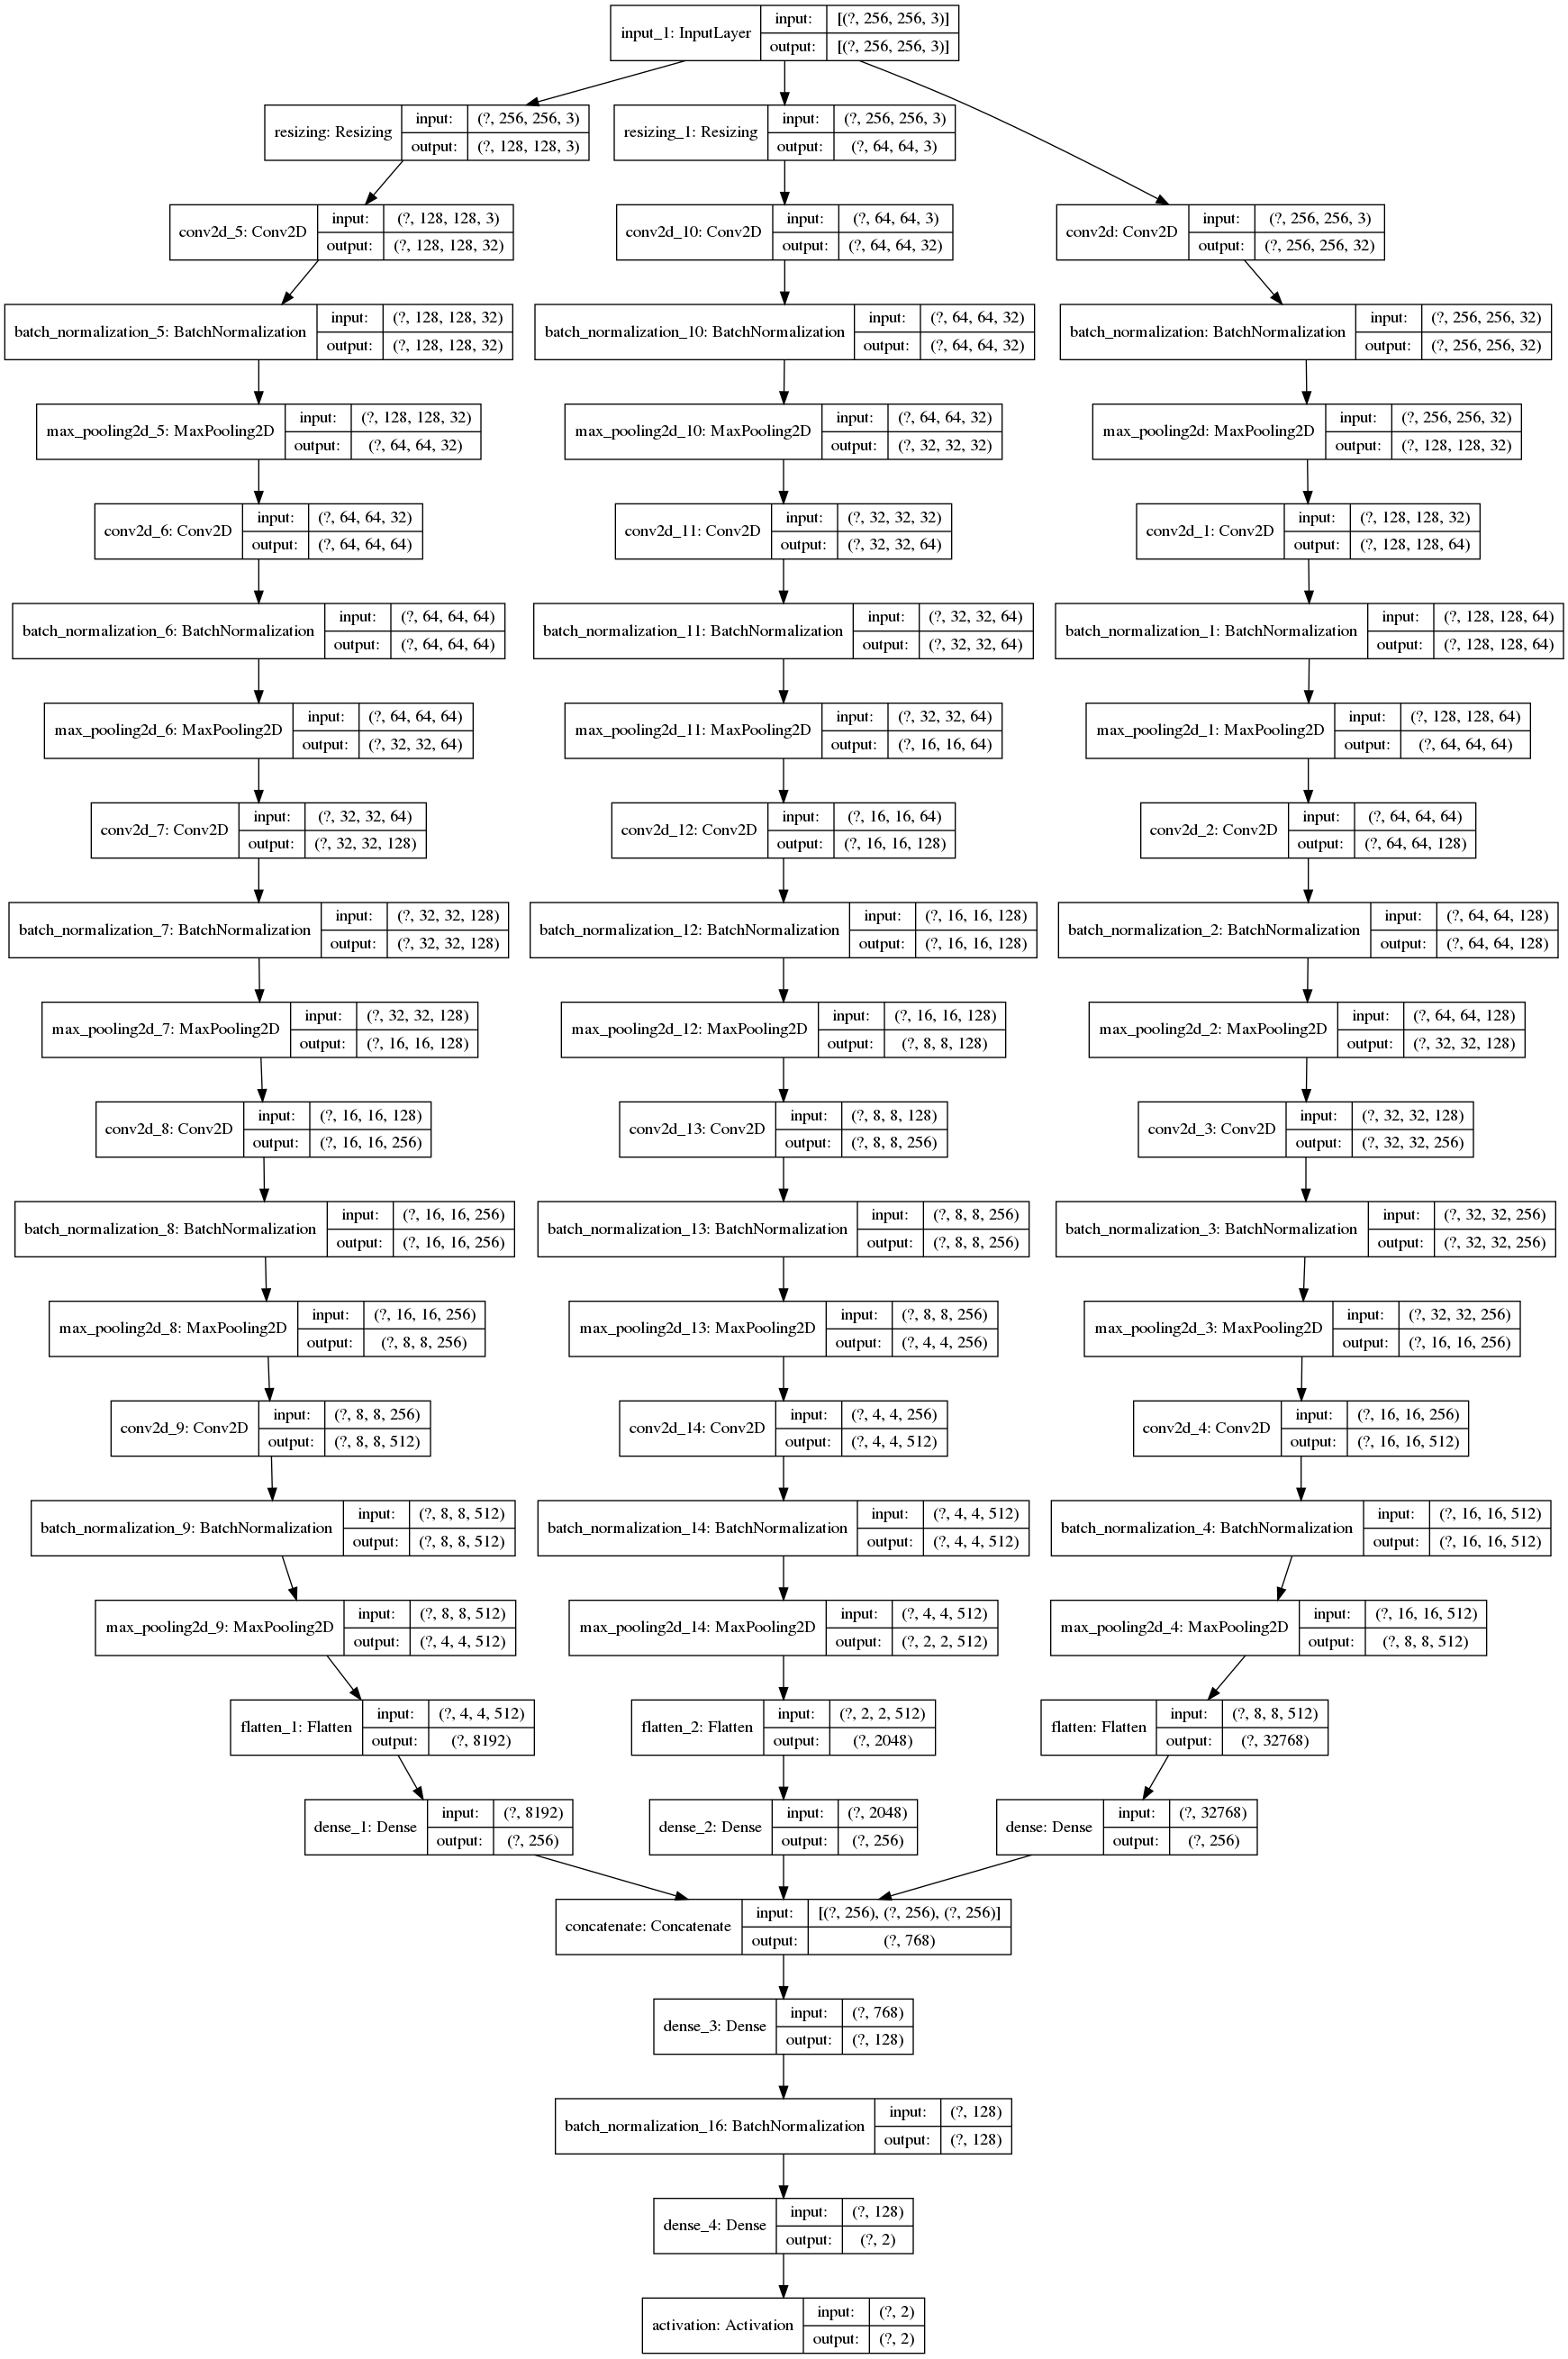

In [10]:
tf.keras.utils.plot_model(final_model, to_file='my_model.png', show_shapes=True)

In [11]:
checkpoint = ModelCheckpoint('best_model_method2.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

lr_scheduler = LearningRateScheduler(lr_schedule)

In [12]:
#final_train_generator = zip(train_generator, train_generator, train_generator)
#final_test_generator  = zip(test_generator, test_generator, test_generator)
final_model.fit_generator(train_generator, steps_per_epoch=STEP_SIZE_TRAIN, epochs=50,
                          validation_data=validation_generator, verbose=1, workers=1, 
                          validation_steps=STEP_SIZE_VALID, callbacks=checkpoint)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/50
304/304 [==============================] - ETA: 0s - loss: 0.6154 - accuracy: 0.6900
Epoch 00001: val_accuracy improved from -inf to 0.56250, saving model to best_model_method2.h5
304/304 [==============================] - 22s 71ms/step - loss: 0.6154 - accuracy: 0.6900 - val_loss: 0.7157 - val_accuracy: 0.5625
Epoch 2/50
304/304 [==============================] - ETA: 0s - loss: 0.3154 - accuracy: 0.8672
Epoch 00002: val_accuracy improved from 0.56250 to 0.60714, saving model to best_model_method2.h5
304/304 [==============================] - 22s 71ms/step - loss: 0.3154 - accuracy: 0.8672 - val_loss: 0.7818 - val_accuracy: 0.6071
Epoch 3/50
304/304 [==============================] - ETA: 0s - loss: 0.1937 - accuracy: 0.9225
Epoch 00003: val_accuracy improved from 0.60714 to 0.64286, saving model to best_model_method2.h5
304/304 [==============================] - 22s 72ms/step - loss: 0.1937 - accur

304/304 [==============================] - ETA: 0s - loss: 0.0363 - accuracy: 0.9868
Epoch 00027: val_accuracy did not improve from 0.73214
304/304 [==============================] - 20s 67ms/step - loss: 0.0363 - accuracy: 0.9868 - val_loss: 8.1895 - val_accuracy: 0.4554
Epoch 28/50
304/304 [==============================] - ETA: 0s - loss: 0.0394 - accuracy: 0.9864
Epoch 00028: val_accuracy did not improve from 0.73214
304/304 [==============================] - 20s 67ms/step - loss: 0.0394 - accuracy: 0.9864 - val_loss: 2.1334 - val_accuracy: 0.7054
Epoch 29/50
304/304 [==============================] - ETA: 0s - loss: 0.0259 - accuracy: 0.9905
Epoch 00029: val_accuracy did not improve from 0.73214
304/304 [==============================] - 20s 67ms/step - loss: 0.0259 - accuracy: 0.9905 - val_loss: 1.2834 - val_accuracy: 0.7143
Epoch 30/50
304/304 [==============================] - ETA: 0s - loss: 0.0429 - accuracy: 0.9840
Epoch 00030: val_accuracy improved from 0.73214 to 0.75893, 

In [13]:
from tensorflow.keras.models import load_model
model = load_model('best_model_method2.h5')

In [14]:
score = model.evaluate_generator(generator=validation_generator, verbose=1,
steps=STEP_SIZE_VALID)

print("Loss: ", score[0], "Accuracy: ", score[1])

Instructions for updating:
Please use Model.evaluate, which supports generators.
7/7 [==============================] - 0s 19ms/step - loss: 0.9292 - accuracy: 0.7589
Loss:  0.9292110204696655 Accuracy:  0.7589285969734192
